# Introduction
The goal of this notebook is to use data to understand the relationship that pressure and temperature play in engine failure.  The type of data you plan on using heavily influences the type of algorithm that's available to use.  Additionally, it's usually a good idea to visualize the data before making any decision about what kind of algorithm to use.

First, let's import the necessary modules and then read in the data.

## Imports

In [1]:
# For manipulating data
import pandas as pd

# For plotting graphs
import matplotlib.pyplot as plt
import graphviz

# For constructing the model
from sklearn.model_selection import train_test_split
from sklearn import tree

# For evaluating model performance
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read data

In [2]:
dataset_url = "https://raw.githubusercontent.com/papir805/Stanford-ML-Class/master/data/engine_failure_data.csv"

# Load the data set.  Use the CSV's first column as the dataframe's index
df = pd.read_csv(dataset_url, index_col=0)

# Check data loaded correctly
df.head()

,pressure (psi),temperature (deg F),failure
0,15.02,192.80,no
1,15.34,199.77,no
2,15.09,197.31,no
3,14.22,199.04,no
4,14.24,205.32,no


In [3]:
# Store label names for x and y
x1_label = 'pressure (psi)'
x2_label = 'temperature (deg F)'

# Store target label name
target_label = 'failure'

# Extract unique target labels
label_0 = 'no'
label_1 = 'yes'

## Visualize the Dataset

In [4]:
# Assign colors based on target_label for visualization
df['color'] = df[target_label].map({label_0:'green', label_1:'red'})

# Seperate the data on engines that failed
# from those that didn't
df_yesses = df[df[target_label]==label_1]
df_nos = df[df[target_label]==label_0]

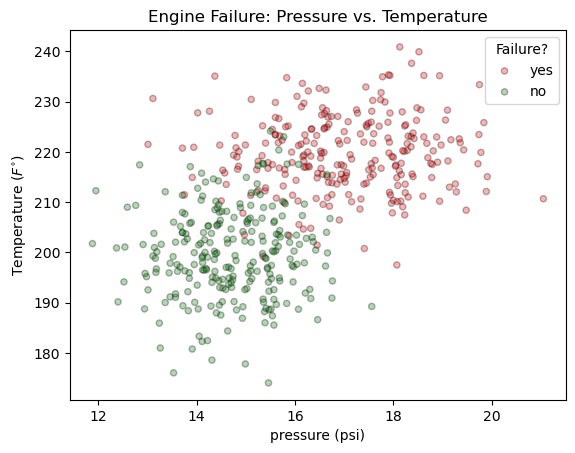

In [5]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Scatter plot of engine data that failed 
ax.scatter(x=df_yesses[x1_label], 
           y=df_yesses[x2_label],
           c=df_yesses['color'],
           label=label_1, s=20, 
           edgecolor="k", alpha=0.3)

# Scatter plot of engine data that didn't fail
ax.scatter(x=df_nos[x1_label], 
           y=df_nos[x2_label],
           c=df_nos['color'],
           label=label_0, s=20, 
           edgecolor="k", alpha=0.3)

ax.set_title('Engine Failure: Pressure vs. Temperature')
ax.set_xlabel(x1_label)
ax.set_ylabel(r'Temperature ($F^{\circ}$)')
ax.legend(title='Failure?')

plt.show()

It looks like higher pressure and/or higher temperature is when most engines in the dataset fail.  Using machine learning, it may be possible to understand the limits of these engines and what range of operating pressures or temperatures are best suited to keep them running.

# Why Decision Trees

The purpose of a decision tree algorithm  is to break down complicated relationships into a series of smaller steps or decisions.  Decision trees are extremely versatile because they can be used for both regression (predicting a quantitative output) or classification (predicting a qualitative output), and can use any number of quantitative or qualitative inputs in making its predictions.  

Furthermore, decision trees are highly interpretable because they are essentially flowcharts in which one asks questions and arrives at some conclusion based on the answers. To understand how the algorithm arrived at its prediction, one simply needs to refer to the flowchart (more on this later).

**Note**: Unlike other algorithms, using both qualitative and quantative inputs is straightforward and requires no special steps to implement properly. 

# Generate Training and Testing Data

While not true in all circumstances, the goal of many ML algorithms is to use the algorithm on new and unseen data at some point.  For this reason, it's important to test the algorithm on unseen data in order to verify its performance and whether or not it will be worthwhile to use.  

This leaves two options:
* Option 1: Build the model now and wait for a sufficient amount of new data to come in, which can be used to verify the model's accuracy.
* Option 2: Parition the dataset into a training set and a testing set.  The training set can be used to build the model and the testing set will only be used to verify the accuracy.

Some may be concerned that by partioning your dataset and then only using part of it to build the model might negatively affect its performance.  After all, it's reasonable to think that the more data points you have the better off it will be, yet in truth there tend to be diminishing returns.  As it turns out, as long as your dataset is sufficiently large, performing a train/test split will still yield quite good results.  Given the alternative is waiting, a train/test split approach is preferred because it will allow you to determine performance immmediately and tweaks to the model can be implemented quickly, if need be.

In [6]:
# Separate feature names
feat_names = [x1_label, x2_label]

In [7]:
# Split dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df[target_label],
                                                    test_size=0.25,
                                                    random_state=42)

# Training the Decision Tree Model

In [8]:
# Create the decision tree classifier object
decision_tree_classifier = tree.DecisionTreeClassifier(max_depth=2, random_state=0)

# Train the model using the training dataset
decision_tree_classifier = decision_tree_classifier.fit(X_train, y_train)

In [9]:
class_labels = decision_tree_classifier.classes_

## Visualizing Decision Tree using Graphviz

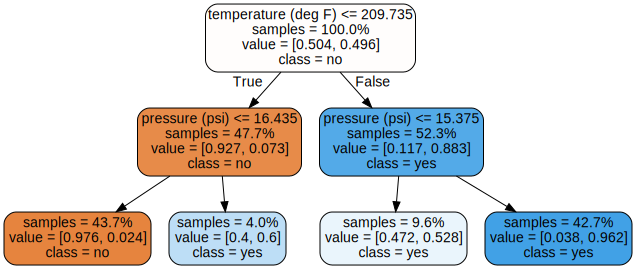

In [11]:
# Create decision tree object and export to Graphviz
dot_data = tree.export_graphviz(decision_tree_classifier, out_file=None,
                                feature_names=feat_names,
                                class_names=class_labels,
                                filled=True, rounded=True,
                                impurity=False, proportion=True)
graph = graphviz.Source(dot_data)

# Show the decision tree
graph

The decision tree seen above represents the model's decision process for predicting engine failure.  Represented as a flowchart, each box is called a node and each arrow from one box to another is called an edge.  At the top of each node is the question one must ask.  Depending on the answer (True vs. False), a different path (edge) will be taken to get to the next node.  

For each new observation, one would start with the topmost node and ask whether the temperature (deg F) of the observation is <= 209.735.  If the answer is yes, then one would follow the True edge to the left.  However, if the answer is no, because the temperature (deg F) of the observation is > 209.735, then one would follow the False edge to the right.  

Each edge leads to a new node with a new question to ask, and the process repeats until one arrives at a nodes on the very bottom of the decision tree, which are referred to as terminal nodes.  The terminal node dictates which prediction the model makes for a given observation.

# Evaluating Model Performance - Testing Data

## Making predictions

Now that the model has been trained, let's make predictions on observations in the testing data.  Using the flowchart from above, we can work through how the model predicted engine failure for a particular observation.

In [12]:
# Make predictions using the already seen training data
predictions = decision_tree_classifier.predict(X_test)
probabilities = decision_tree_classifier.predict_proba(X_test)

results_df = pd.DataFrame({x1_label:X_test[x1_label],
                           x2_label:X_test[x2_label],
                         #'prob of no':probabilities[:,0],
                         'prob of fail':probabilities[:,1],
                         'predicted failure':predictions,
                         'actual failure': y_test})
results_df.head()

,pressure (psi),temperature (deg F),prob of fail,predicted failure,actual failure
361,17.93,235.23,0.962500,yes,yes
73,14.03,188.73,0.024390,no,no
374,15.93,219.96,0.962500,yes,yes
155,14.94,204.14,0.024390,no,no
104,11.95,212.28,0.527778,yes,no


Let's focus on the observation in the second row of the results_df shown above.  The observation has $\text{pressure (psi)} = 14.03$ and $\text{temperature (deg F)}$ = 188.73, and the model predicted no engine failure.  

To begin the process, one would start at the very top most node in the flowchart and ask whether temperature <= 209.735.  This is true, because the temperature of the observation is 188.73, and the leftward edge would be taken.  This leads to a node asking whether pressure <= 16.435.  This is also true, because the pressure is 14.03, and the leftward edge would be taken, leading to a terminal node, where the predicted class is no.  

Based on the decision tree, this observation would be predicted to have no engine failure, which is correct.  The results_df shows confirms that this observation had no engine failure.

## Checking Accuracy

Predicting a qualitative output is commonly referred to as a classification problem.  In this example, the goal is to classify an engine and either failing or not failing based on pressure and temperature.  The most common metric for evaluating performance is known as accuracy, which represents the percentage of predictions that were correct:

$$\text{accuracy}=\frac{n \text{ correct predictions}}{m \text{ total predictions}}$$ 

In [13]:
accuracy = decision_tree_classifier.score(X_test, y_test)
accuracy

0.92

The model has high accuracy on testing data, correctly predicting when an engine will fail 92% of the time.  The model appears to do well on unseen data, giving confidence that it generalizes to new data well.

## Visualizing Decision Boundaries

The decision boundary represents the boundary between the algorithm predicting one label versus another.  Depending on what side of the boundary an observation is on, the algorithm will predict the label corresponding to that side.

In [14]:
# Create copy of X_test data
X_test_copy = X_test.copy(deep=True)

# Assign failure labels
X_test_copy[target_label] = y_test

# Assign colors
colors = []
for y in y_test:
    if y == 'yes':
        colors.append('red')
    else:
        colors.append('green')
X_test_copy['color'] = colors

# Separate failed engines from non-failed engines 
test_yesses = X_test_copy[X_test_copy[target_label]=='yes']
test_nos = X_test_copy[X_test_copy[target_label]=='no']

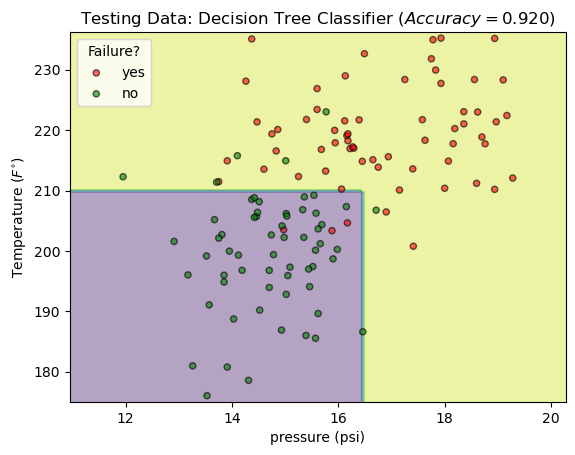

In [15]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Draw the model's decision boundary, a boundary separating
# where it predicts a failure from a non-failure
DecisionBoundaryDisplay.from_estimator(estimator=decision_tree_classifier, 
                                       X=X_test, 
                                       alpha=0.4, 
                                       response_method="predict", 
                                       ax=ax)

# Scatter plot of engine data that failed 
ax.scatter(x=test_yesses[x1_label], 
           y=test_yesses[x2_label], 
           c=test_yesses['color'], 
           s=20, edgecolor="k", label='yes', alpha=0.6)

# Scatter plot of engine data that didn't fail
ax.scatter(x=test_nos[x1_label],
           y=test_nos[x2_label],
           c=test_nos['color'], 
           s=20, edgecolor="k", label='no', alpha=0.6)

ax.set_title(f'Testing Data: Decision Tree Classifier $(Accuracy = {accuracy:.3f})$')
ax.set_ylabel(r'Temperature ($F^{\circ}$)')
ax.legend(title='Failure?')

#plt.tight_layout()
plt.show()

This graph acts as a visual representation of the flowchart seen earlier.  The purple area of the graph corresponds to an observation having $\text{temperature (deg F)} <= 209.735$ and $\text{pressure (psi)} <= 16.435$. The model would predict any observation in this region to have no engine failure.  

Observations that actually had no engine failure are represented by the green dots, and most of them fall in the purple region.  This is good, these are correct predictions.  There are a few red dots in the purple region, though, representing engines that actually failed, yet were predicted by the model to have no failure, and are thus incorrect predictions.  

On the other hand, the yellow region represents where the model would predict engine failure.  Most of the red dots, engines that actually failed, are in the yellow region and thus represent correct predictions, although there are a few green dots representing incorrect predictions.

Overall, the model is doing a reasonably well at correctly making predictions.

## Confusion Matrix

A confusion matrix helps get a slightly better picture of the model's predictive accuracy.  It enables one to see how many correct and incorrect predictions occurred.

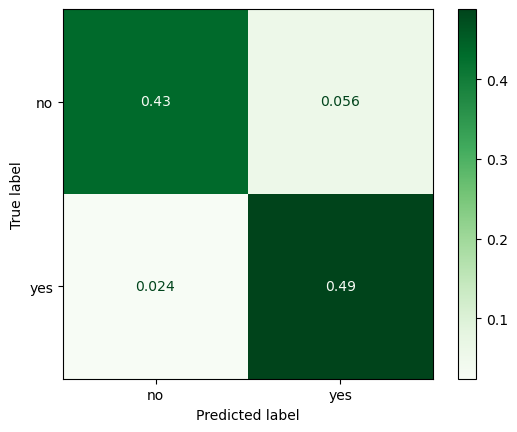

In [18]:
# Create confusion matrix object
cm = confusion_matrix(y_true=y_test, 
                      y_pred=predictions,
                      labels=class_labels,
                      normalize='all')

# Create confusion matrix display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=class_labels)

# Graph confusion matrix display
cm_display.plot(cmap='Greens')

plt.show()

The confusion matrix further breaks down the accuracy score shown early.  It shows the model correctly predicts engine failure 49% of the time and correctly predicts when an engine won't fail 43% of the time, giving a total of 92% accuracy.  Furthermore, the model incorrectly predicts when an engine won't fail 2.4% of the time and incorrectly predicts when an engine will fail 5.6% of the time.

# Conclusion

By visualizing the dataset, it was clear that some kind of relationship existing between the pressure and temperature of an engine and whether or not it would fail.  A decision tree classifier was able to pick up on this relationship and performed reasonably well on testing data, with an overall predictive accuracy of 92%.